Ссылка на дашборд: https://public.tableau.com/app/profile/alex3587/viz/SpaceBro_16271336593410/SpaceBroDashboard?publish=yes  
Ссылка на презентацию: https://disk.yandex.ru/i/TDSfJ4eddkeLQA

# Формирование модели монетизации мобильной игры

**Цель проекта** - сформировать модель монетизации мобильной игры "Космические братья". Нужно определить оптимальный момент для начала показа рекламы, а также частоту показа рекламы.  

**Задачи проекта**:
- Исследование данных
- Исследование влияния событий на совершение целевого действия (завершение первого уровня)
- Формирование модели монетизации
- Проверка гипотез

**Описание данных**:

*game_actions:*  
- event_datetime - время события
- event - тип события
- building_type - тип здания
- user_id - идентификатор пользователя
- project_type - тип реализованного проекта

*ad_cost:*  
- day - день, в который был совершен клик по объявлению
- source - источник трафика
- cost - стоимость кликов  

*user_source:*  
- user_id - идентификатор пользователя
- source - источников, с которого пришёл пользователь, установивший приложение

**Содержание**:
1. <a href="#Импорт-библиотек-и-загрузка-данных">Импорт библиотек и загрузка данных</a>
2. <a href="#Изучение-стратегий-игроков">Изучение стратегий игроков</a>
3. <a href="#Исследовательский-анализ-данных">Исследовательский анализ данных</a>
4. <a href="#Исследования-влияния-событий-на-совершение-целевого-действия">Исследования влияния событий на совершение целевого действия</a>
5. <a href="#Проверка-гипотез">Проверка гипотез</a>
6. <a href="#Итоговый-вывод">Итоговый вывод</a>

### Импорт библиотек и загрузка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import levene
from scipy import stats as st
import math as mth
import statsmodels.stats.multitest as smt
from termcolor import colored

In [2]:
sns.set_style('whitegrid')

Загрузим исходные данные

In [3]:
game_actions = pd.read_csv('/datasets/game_actions.csv')
game_actions.name = 'Game actions'

ad_costs = pd.read_csv('/datasets/ad_costs.csv')
ad_costs.name = 'Advertisment costs'

user_source = pd.read_csv('/datasets/user_source.csv')
user_source.name = 'User source'

Создадим функцию для быстрого и удобного знакомства с данными

In [4]:
def first_look(df, sample_size=5):
    print(f'\nДатафрейм {df.name}:')
    display(df.sample(sample_size))
    df.info()
    
    na_count = df.isna().sum()
    duplicates_count = df.duplicated().sum()
    
    print('\nКоличество пропусков в столбцах:')
    print(na_count)
    print('\nКоличество дубликатов: ', duplicates_count)
    print('----------------------------------')

Взглянем на данные

In [5]:
for df in [game_actions, ad_costs, user_source]:
    first_look(df)


Датафрейм Game actions:


,event_datetime,event,building_type,user_id,project_type
2911,2020-05-04 08:53:26,building,assembly_shop,790c6c30-a30f-4491-87c5-ca767290ac6c,NaN
77004,2020-05-10 21:54:58,building,spaceport,644ada9f-65ef-4a79-8c20-1379248292e5,NaN
96577,2020-05-13 06:23:22,building,research_center,c8264dd1-9119-4e03-b37b-71319f9647a7,NaN
105386,2020-05-14 11:11:38,building,spaceport,c37a8de8-fb8e-4a95-885e-a6b527212eb5,NaN
132781,2020-05-22 09:44:26,building,spaceport,2d0f30db-21e3-4f51-8bb8-7f0f77d04774,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB

Количество пропусков в столбцах:
event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Количество дубликатов:  1
----------------------------------

Датафрейм Advertisment costs:


,source,day,cost
8,instagram_new_adverts,2020-05-04,502.925451
20,yandex_direct,2020-05-09,42.779505
19,yandex_direct,2020-05-08,62.961630
2,facebook_ads,2020-05-05,260.185754
6,facebook_ads,2020-05-09,38.723350


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes

Количество пропусков в столбцах:
source    0
day       0
cost      0
dtype: int64

Количество дубликатов:  0
----------------------------------

Датафрейм User source:


,user_id,source
11270,d5c3fad5-5a12-4f1c-855e-eaf08bc2f4fa,instagram_new_adverts
11605,db2213d2-392c-4c60-8a6f-a7a0b9f4d927,facebook_ads
5478,66345c2e-e93e-4859-98d2-ebbd377f2e21,yandex_direct
2208,27effca9-efae-43de-910f-2c1e56c9bb7a,yandex_direct
13492,fe5cbe12-8675-4761-b45f-3fbe413b2689,yandex_direct


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB

Количество пропусков в столбцах:
user_id    0
source     0
dtype: int64

Количество дубликатов:  0
----------------------------------


**Выводы**  
game_actions:
- Пропуски в столбце *building_type* означают, что событие было не *building*
- Пропуски в столбце *project_type* означают, что событие было не *project*
- Переименовать столбец *event* в *event_type*
- Посмотреть на единственный дубликат
- Сменить тип столбца *event_datetime* на дату

ad_costs:
- Сменить тип столбца *day* на дату

Переименуем столбец.

In [6]:
game_actions.rename(columns={'event': 'event_type'}, inplace=True)

Взглянем на дубликаты.

In [7]:
game_actions[game_actions.duplicated(keep=False)]

,event_datetime,event_type,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Похоже на обычный дубликат. Ну или игрок с указанным событием умудрился построить 2 одинаковых здания за одну секунду. Удалим дубликат.

In [8]:
game_actions.drop_duplicates(keep='first', inplace=True)

Сменим типы столбцов.

In [9]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

**Предобработка завершена**

### Изучение стратегий игроков

Для начала разберемся со стратегиями игроков. Итогом этой деятельности будет датафрейм, устанавливающий соответствие *id* игрока и его стратегии.  
Под стратегией понимается способ завершения первого уровня.  

Возможные стратегии:
- Завершение уровня победой над игроком
- Завершение уровня реализацией проекта  

Так же стоит выделить тех игроков, которые в игре что-то делали, но уровень не завершили.  

Выделим тех игроков, которые завершили проект. События *project* и *finished_stage_1* для каждого игрока могут наступать только единожды, поэтому нет необходимости выделять уникальные *user_id*.

In [10]:
project_finished = game_actions.loc[game_actions['event_type'] == 'project']['user_id']
project_finished.shape[0]

1866

Выделим всех, кто завершил первый уровень.

In [11]:
finished_stage_1 = game_actions.loc[game_actions['event_type'] == 'finished_stage_1']['user_id']
finished_stage_1.shape[0]

5817

Составим список игроков, завершивших первый уровень реализацией проекта.

In [12]:
finished_stage_1_by_project = finished_stage_1[finished_stage_1.isin(project_finished)]
finished_stage_1_by_project.shape[0]

1866

Составим список игроков, завершивших первый уровень победой над другим игроком. Это те пользователи, которые завершили первый уровень, но не реализовывали проект.

In [13]:
finished_stage_1_by_win = finished_stage_1[~finished_stage_1.isin(project_finished)]
finished_stage_1_by_win.shape[0]

3951

Найдем игроков, которые не завершили первый уровень.

In [14]:
not_finished_stage_1 = game_actions[~game_actions['user_id'].isin(finished_stage_1)]['user_id'].unique()
not_finished_stage_1.shape[0]

7759

**Зафиксируем**:
- Всего уникальных игроков, совершивших события: 13576
- Завершили первый уровень: 5817 (43%)
    - Победой над игроком: 3951 (68% от завершивших первый уровень)
    - Реализацией проекта: 1866 (32% от завершивших первый уровень)
- Не завершили первый уровень: 7759 (57%)
- Все игроки строили объекты

Создадим датафрейм.

In [15]:
strategies = pd.DataFrame(game_actions['user_id'].unique(), columns=['user_id'])
strategies['strategy'] = 'not_finished'
strategies.loc[strategies['user_id'].isin(finished_stage_1_by_win), 'strategy'] = 'win'
strategies.loc[strategies['user_id'].isin(finished_stage_1_by_project), 'strategy'] = 'project'
strategies.head(5)

,user_id,strategy
0,55e92310-cb8e-4754-b622-597e124b03de,not_finished
1,c07b1c10-f477-44dc-81dc-ec82254b1347,project
2,6edd42cc-e753-4ff6-a947-2107cd560710,win
3,92c69003-d60a-444a-827f-8cc51bf6bf4c,not_finished
4,cdc6bb92-0ccb-4490-9866-ef142f09139d,win


In [16]:
game_actions = game_actions.merge(strategies, how='left', on='user_id')

### Исследовательский анализ данных

Для каждой стратегии построим распределение количества построенных объектов на одного игрока.

In [17]:
actions_grouped_by_user = game_actions[
    game_actions['event_type'] == 'building'
].groupby(['user_id', 'strategy'])[['event_type']].count().reset_index()

actions_grouped_by_user.columns = ['user_id', 'strategy', 'events_count']

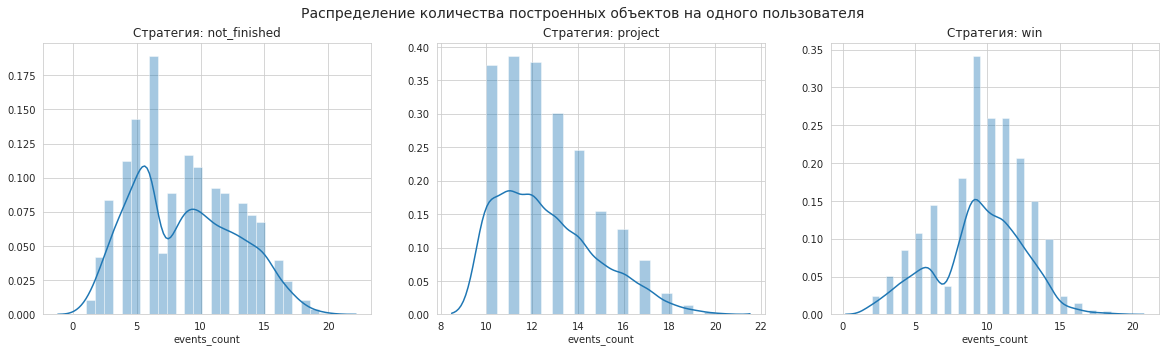

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle(f'Распределение количества построенных объектов на одного пользователя', fontsize=14)

for ax, strategy in zip(axes, strategies['strategy']):
    ax.set_title(f'Стратегия: {strategy}')
    ax.set_xlabel('Количество событий')
    sns.distplot(
        actions_grouped_by_user[actions_grouped_by_user['strategy'] == strategy]['events_count'], ax=ax)


- Те, кто не закончил первый уровень в среднем строят меньше объектов, чем игроки, завершившие его
- Игроки, реализовавшие проект, в среднем строят больше всех объектов. При чем минимальное количество объектов, которое нужно построить для реализации проекта - 10
- Игроки, победившие своего противника, строят среднее количество объектов

Узнаем сколько объектов разных типов было построено.

In [19]:
actions_grouped_by_building_type = game_actions.groupby('building_type')['event_type'].count().reset_index()
actions_grouped_by_building_type.columns = ['building_type', 'count']

actions_grouped_by_building_type

,building_type,count
0,assembly_shop,54494
1,research_center,14137
2,spaceport,59325


Построим столбчатую диаграмму.

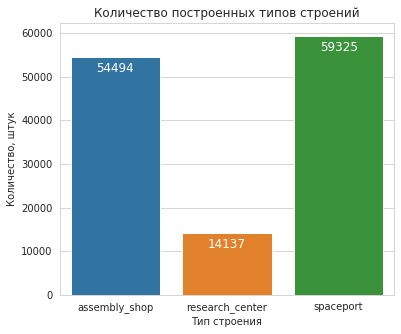

In [20]:
plt.figure(figsize=(6, 5))
sns.barplot(x=actions_grouped_by_building_type['building_type'], y=actions_grouped_by_building_type['count'])
plt.title('Количество построенных типов строений')
plt.xlabel('Тип строения')
plt.ylabel('Количество, штук')

for x, y in zip(range(len(actions_grouped_by_building_type['building_type'])), actions_grouped_by_building_type['count']):
    plt.annotate(y, (x,y), textcoords="offset points", xytext=(0,-15), ha='center', color='white', fontsize=12)
    
plt.show()

Диаграмма говорит сама за себя: *assemply_shop* и *spaceport* были простроены примерно одинаковое количество раз, а *research_center* строят гораздо реже.  

Изучим распределение количества событий по дням

In [21]:
game_actions['event_day'] = game_actions['event_datetime'].dt.date

actions_grouped_by_date = game_actions.groupby(['event_day'])[['user_id']].count().reset_index()
actions_grouped_by_date.columns = ['event_day', 'events_count']

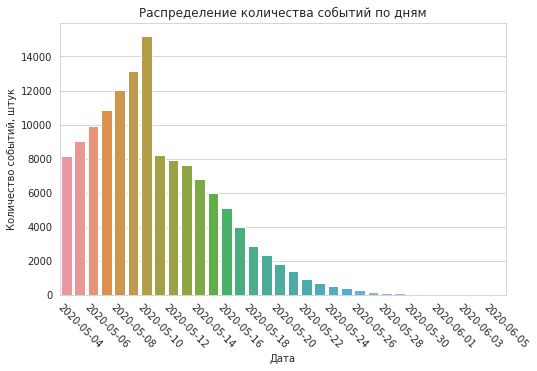

In [22]:
plt.figure(figsize=(8, 5))
sns.barplot(x=actions_grouped_by_date['event_day'], y=actions_grouped_by_date['events_count'], color=None)
plt.xticks(
    ticks=[x+1 for x in range(0, len(actions_grouped_by_date['event_day']), 2)], 
    labels=actions_grouped_by_date['event_day'][0::2], 
    rotation=-45
)
plt.title('Распределение количества событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий, штук')
plt.show()

До 10-го мая количество событий растёт, а с 11-го мая количество событий уменьшается, практически достигая нуля 5-го июня. Причины:  
- До 10-го числа игра рекламируется, что обеспечивает активный приток новых игроков
- В начале первого уровня наверняка строительство объектов идет более активно, чем ближе к его концу
- Уже в районе 10-го числа начинают появляться игроки, которые уже завершили первый уровень  

Изучим распределение стоимости кликов по рекламе нашей игры по дням.

In [23]:
ad_costs_grouped_by_day = ad_costs.groupby(['day', 'source'])[['cost']].sum().reset_index()
ad_costs_grouped_by_day.columns = ['day', 'source', 'costs']
ad_costs_grouped_by_day['day'] = ad_costs_grouped_by_day['day'].dt.date

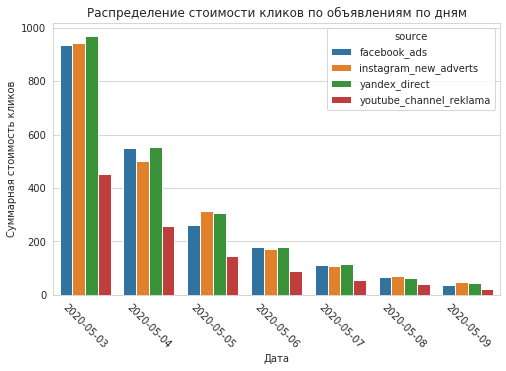

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(x=ad_costs_grouped_by_day['day'], y=ad_costs_grouped_by_day['costs'], hue=ad_costs_grouped_by_day['source'])
plt.xticks(ticks=[x for x in range(0, len(ad_costs_grouped_by_day['day'].unique()))], rotation=-45)
plt.title('Распределение стоимости кликов по объявлениям по дням')
plt.xlabel('Дата')
plt.ylabel('Суммарная стоимость кликов')
plt.show()

С каждым днём суммарная стоимость кликов падает, однако пропорции между маркетинговыми источниками сохраняются.  
- Затраты на источники *facebook_ads*, *instagram_new_adverts* и *yandex_direct* примерно одинаковы
- Затраты на источник *youtube_channel_reklama* примерно вдвое меньше, чем затраты на остальные источники

Изучим сколько людей пришли к нам из каждого источника.

In [25]:
user_source_grouped = user_source.groupby('source')[['user_id']].count().reset_index()
user_source_grouped.columns = ['source', 'users_count']
user_source_grouped

,source,users_count
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


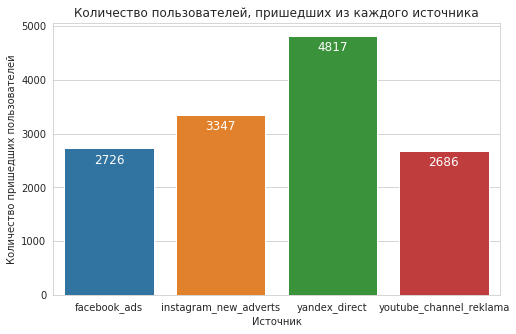

In [26]:
plt.figure(figsize=(8, 5))
sns.barplot(x=user_source_grouped['source'], y=user_source_grouped['users_count'])
plt.title('Количество пользователей, пришедших из каждого источника')
plt.xlabel('Источник')
plt.ylabel('Количество пришедших пользователей')

for x, y in zip(range(len(user_source_grouped['source'])), user_source_grouped['users_count']):
    plt.annotate(y, (x,y), textcoords="offset points", xytext=(0,-15), ha='center', color='white', fontsize=12)

plt.show()

Больше всего новых пользователей принесла реклама в *yandex_direct*. Удивительно, что источники *facebook_ads* и *youtube_channel_reklama* принесли примерно одинаковое количество пользователей, не смотря на сильно отличающиеся вложения.  

Вычислим среднюю стоимость привлечения одного нового пользователя из каждого источника.

In [27]:
cost_per_user = user_source_grouped.merge(
    ad_costs.groupby('source')[['cost']].sum().reset_index(), 
    how='inner', on='source'
)
cost_per_user['per_user'] = cost_per_user['cost'] / cost_per_user['users_count']
cost_per_user

,source,users_count,cost,per_user
0,facebook_ads,2726,2140.904643,0.785365
1,instagram_new_adverts,3347,2161.441691,0.645785
2,yandex_direct,4817,2233.111449,0.463590
3,youtube_channel_reklama,2686,1068.119204,0.397662


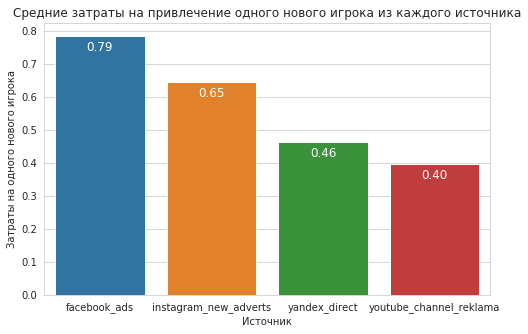

In [28]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cost_per_user['source'], y=cost_per_user['per_user'])
plt.title('Средние затраты на привлечение одного нового игрока из каждого источника')
plt.xlabel('Источник')
plt.ylabel('Затраты на одного нового игрока')

for x, y in zip(range(len(cost_per_user['source'])), cost_per_user['per_user']):
    plt.annotate(f'{y:.2f}', (x,y), textcoords="offset points", xytext=(0,-15), ha='center', color='white', fontsize=12)

plt.show()

Лучше всего по показателю "средние затраты на привлечение одного пользователя" работает реклама в источниках *yandex_direct* и *youtube_channel_reklama*.

### Исследования влияния событий на совершение целевого действия  

Целевое событие - завершение первого уровня. Исследуем группы пользователей с разными стратегиями. Посмотрим на то, кто сколько каких объектов строит в среднем.

In [29]:
actions_grouped_by_strategy = game_actions[
    game_actions['event_type'] == 'building'
].groupby(['strategy', 'building_type'])[['event_type', 'user_id']].agg(
    {'event_type':'count', 'user_id':'nunique'}
).reset_index()
actions_grouped_by_strategy.columns = ['strategy', 'building_type', 'events_count', 'unique_users_count']
actions_grouped_by_strategy['avg_events'] = actions_grouped_by_strategy['events_count'] / actions_grouped_by_strategy['unique_users_count']
actions_grouped_by_strategy

,strategy,building_type,events_count,unique_users_count,avg_events
0,not_finished,assembly_shop,29080,7759,3.747906
1,not_finished,research_center,6685,3463,1.930407
2,not_finished,spaceport,31405,7471,4.203587
3,project,assembly_shop,9116,1866,4.885316
4,project,research_center,3697,1866,1.981243
5,project,spaceport,10788,1866,5.781350
6,win,assembly_shop,16298,3951,4.125032
7,win,research_center,3755,2342,1.603330
8,win,spaceport,17132,3894,4.399589


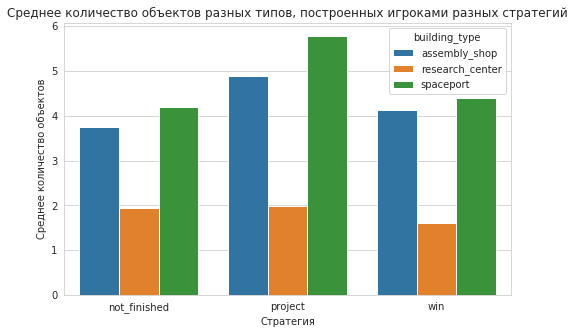

In [30]:
plt.figure(figsize=(8, 5))

sns.barplot(
    x=actions_grouped_by_strategy['strategy'], 
    y=actions_grouped_by_strategy['avg_events'], 
    hue=actions_grouped_by_strategy['building_type']
)

plt.title('Среднее количество объектов разных типов, построенных игроками разных стратегий')
plt.xlabel('Стратегия')
plt.ylabel('Среднее количество объектов')

plt.show()

Судя по диаграмме, для реализации проекта требуется большее количество объектов всех типов, чем для победы над другим игроком.  
Определим параметры показа рекламы, при которых достигается окупаемость маркетинговых вложений.  
Параметры:
- ad_cost_per_1000 - стоимость 1000 показов рекламы
- ad_rate - процент экранов с выбором типа объекта, на которых будут показывать рекламу
- ad_begin - номер объекта, начиная с которого будет показываться реклама

In [38]:
# Функция, которая при помощи когорт осуществляет расчет ROMI

def calculate_payback(game_actions, ad_costs, ad_cost_per_1000, ad_rate, ad_begin):
    ad_profit = game_actions[game_actions['event_type'] == 'building'][['user_id', 'event_day', 'strategy']]
    ad_profit['ad_profit'] = (ad_cost_per_1000 / 1000) * ad_rate
    
    builders_count = game_actions[game_actions['event_type'] == 'building']['user_id'].nunique()
    
    part = 1 - builders_count * ad_begin / game_actions[game_actions['event_type'] == 'building'].shape[0]
    
    ad_profit = ad_profit.sample(frac = part)
    
    daily_ad_costs = ad_costs.groupby('day')['cost'].sum().reset_index()
    daily_ad_costs.columns = ['day', 'costs_sum']
    daily_ad_costs['day'] = daily_ad_costs['day'] + datetime.timedelta(days=1)
    
    first_actions = ad_profit.groupby('user_id').agg({'event_day': 'min'}).reset_index()
    first_actions.columns = ['user_id', 'first_action_day']
    
    cohort_sizes = (
        first_actions.groupby('first_action_day')
        .agg({'user_id': 'nunique'})
        .reset_index()
    )
    cohort_sizes.columns = ['first_action_day', 'n_buyers']
    
    ad_profit = pd.merge(ad_profit, first_actions, on='user_id')
    
    cohorts = (
        ad_profit.groupby(['first_action_day', 'event_day'])
        .agg({'ad_profit': 'sum'})
        .reset_index()
    )
    
    report = pd.merge(cohort_sizes, cohorts, on='first_action_day')
    report['age'] = (
        report['event_day'] - report['first_action_day']
    ) / np.timedelta64(1, 'D')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['ad_profit'] / report['n_buyers']
    report['first_action_day'] = pd.to_datetime(report['first_action_day'])
    
    report = report.merge(daily_ad_costs, how='left', left_on='first_action_day', right_on='day')
    report['cac'] = report['costs_sum'] / report['n_buyers']
    report['romi'] = report['ltv'] / report['cac']
    
    output = report.pivot_table(
        index='first_action_day', columns='age', values='romi', aggfunc='mean'
    )
    
    return (pd.DataFrame(output.cumsum(axis=1).mean(axis=0)), report)

Ниже исследуются комбинации параметров *ad_rate* и *ad_begin* в следующих диапазонах:
- ad_rate от 0.1 до 1
- ad_begin от 0 до 6

In [39]:
for ad_rate in [x / 10 for x in range(1, 11)]:
    for ad_begin in range(7):
        payback_period, _ = calculate_payback(game_actions, ad_costs, 140, ad_rate, ad_begin)
        payback_period = payback_period.reset_index()
        payback_period.columns = ['age','romi']
        payback_period = payback_period[payback_period["romi"] > 1]
        if payback_period.shape[0] != 0:
            print(
                f'''
            ad_rate={ad_rate}, ad_begin={ad_begin}: 
            payback age= {payback_period.iloc[0]['age'].astype('int')}, 
            max_romi={payback_period['romi'].max():.3f},
            max_romi_age={payback_period[payback_period['romi'] == payback_period['romi'].max()]['age'].values[0]}'''
                 )
        else:
            print(f'ad_rate={ad_rate}, ad_begin={ad_begin}: не окупается')

ad_rate=0.1, ad_begin=0: не окупается
ad_rate=0.1, ad_begin=1: не окупается
ad_rate=0.1, ad_begin=2: не окупается
ad_rate=0.1, ad_begin=3: не окупается
ad_rate=0.1, ad_begin=4: не окупается
ad_rate=0.1, ad_begin=5: не окупается
ad_rate=0.1, ad_begin=6: не окупается
ad_rate=0.2, ad_begin=0: не окупается
ad_rate=0.2, ad_begin=1: не окупается
ad_rate=0.2, ad_begin=2: не окупается
ad_rate=0.2, ad_begin=3: не окупается
ad_rate=0.2, ad_begin=4: не окупается
ad_rate=0.2, ad_begin=5: не окупается
ad_rate=0.2, ad_begin=6: не окупается
ad_rate=0.3, ad_begin=0: не окупается
ad_rate=0.3, ad_begin=1: не окупается
ad_rate=0.3, ad_begin=2: не окупается
ad_rate=0.3, ad_begin=3: не окупается
ad_rate=0.3, ad_begin=4: не окупается
ad_rate=0.3, ad_begin=5: не окупается
ad_rate=0.3, ad_begin=6: не окупается

            ad_rate=0.4, ad_begin=0: 
            payback age= 31, 
            max_romi=1.028,
            max_romi_age=31
ad_rate=0.4, ad_begin=1: не окупается
ad_rate=0.4, ad_begin=2: не окупается
a

*payback_age* показывает день, на который окупаются маркетинговые затраты;  
*max_romi* показывает максимальное значение ROMI для данной комбинации параметров;  
*max_romi_age* показывает день, на который достигается максимальное значение ROMI.  

Общая тенденция: чем более агрессивная реклама (показывается при каждой постройке объекта, начиная с первого), тем быстрее окупится реклама и тем больше будет конечный ROMI. Однако в таком случае велика вероятность потерять лояльность игроков, утомив их рекламой.  

Если есть определенный уровень ROMI, который необходимо достигнуть, то по выводу выше можно понять какое сочетание параметров стоит использовать.  

Для того, чтобы выявить влияние выбранных параметров показа рекламы на лояльность игроков, необходимо провести несколько A/B-тестов.

Изучим время, которое прошло между первым и последним событием каждого игрока. На всякий случай обратим внимание и на игроков, которые не завершили первый уровень.  

Последнее событие каждого завершившего первый уровень игрока - *finished_stage_1*. Для игроков, не завершивших первый уровень, учитывается время между первым и последним событием.

In [40]:
time_of_play = game_actions.groupby(['user_id', 'strategy'])['event_datetime'].agg(['first', 'last']).reset_index()
time_of_play.columns = ['user_id', 'strategy', 'first_event_dt', 'last_event_dt']
time_of_play['delta_dt'] = time_of_play['last_event_dt'] - time_of_play['first_event_dt']
time_of_play['delta_int'] = time_of_play['delta_dt'].astype(np.int64)
time_of_play.head(5)

,user_id,strategy,first_event_dt,last_event_dt,delta_dt,delta_int
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_finished,2020-05-06 01:07:37,2020-05-20 11:26:06,14 days 10:18:29,1246709000000000
1,00151b4f-ba38-44a8-a650-d7cf130a0105,not_finished,2020-05-06 03:09:12,2020-05-18 10:46:52,12 days 07:37:40,1064260000000000
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,not_finished,2020-05-05 18:08:52,2020-05-14 09:21:27,8 days 15:12:35,745955000000000
3,001d39dc-366c-4021-9604-6a3b9ff01e25,win,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,556722000000000
4,002f508f-67b6-479f-814b-b05f00d4e995,not_finished,2020-05-05 13:49:58,2020-05-22 02:46:45,16 days 12:56:47,1429007000000000


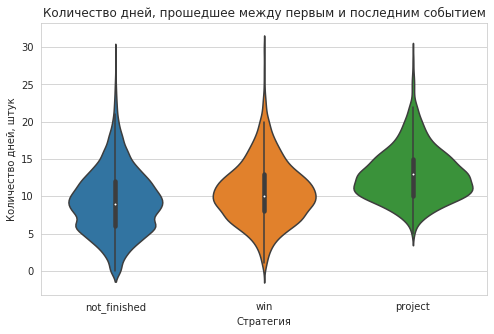

In [41]:
plt.figure(figsize=(8, 5))
sns.violinplot(x=time_of_play['strategy'], y=time_of_play['delta_dt'].astype('timedelta64[D]'))
plt.title('Количество дней, прошедшее между первым и последним событием')
plt.xlabel('Стратегия')
plt.ylabel('Количество дней, штук')

plt.show()

Выводы:
- Распределения близки к нормальным, но у всех стратегий есть тяжелые правые хвосты
- Дисперсии выборок сильно различаются
- Некоторые игроки одержали победу над своим противником практически сразу
- Для завершения проекта требовалось минимум 4 дня
- Игроки, не завершившие первый уровень, всё равно проводили в игре достаточно много времени с точки зрения разности между первым и последним событием  

### Проверка гипотез

Проверим гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.  
Сформируем нулевую и альтернативную гипотезы:
- H0 - различий нет
- H1 - различия есть  

Для проверки различия средних значений двух выборок подходит метод scipy.stats.ttest_ind(), проверять будем двухстороннюю гипотезу.  

Вычислим среднее время между первым и последним событием.  

In [42]:
delta_grouped_by_strategy = time_of_play.groupby('strategy')['delta_int'].mean().reset_index()
delta_grouped_by_strategy.columns = ['strategy', 'delta_int']
delta_grouped_by_strategy['delta_dt'] = pd.to_timedelta(delta_grouped_by_strategy['delta_int'])
delta_grouped_by_strategy

,strategy,delta_int,delta_dt
0,not_finished,8.456983e+14,9 days 18:54:58.255445
1,project,1.162849e+15,13 days 11:00:49.135048
2,win,9.594241e+14,11 days 02:30:24.076183


Разница видна, однако значима ли она?  

Сформируем выборки.

In [43]:
delta_project = time_of_play[time_of_play['strategy'] == 'project']['delta_int']
delta_win = time_of_play[time_of_play['strategy'] == 'win']['delta_int']

Параметр *alpha* установим в 0.05. Выборки имеют разные дисперсии, поэтому параметр *equal_var* равен False.

In [44]:
alpha = 0.05

results = st.ttest_ind(delta_project, delta_win, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.708058235070199e-107
Отвергаем нулевую гипотезу


p-value крайне мало, что даёт основания отвергнуть нулевую гипотезу в пользу альтернативной. **Разница** во времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком, **есть**.

Проверим еще одну гипотезу.
Гипотеза: доли пользователей, закончивших первый уровень, не различаются в зависимости от источника, из которого пришел пользователь.  
- H0 - доли не различаются
- H1 - доли различаются

Для проверки долей воспользуемся z-тестом.

Сформируем выборки.

In [45]:
user_source_strategy = user_source.merge(strategies, how='left', on='user_id')

In [46]:
fb_source = user_source_strategy[user_source_strategy['source'] == 'facebook_ads']
yandex_source = user_source_strategy[user_source_strategy['source'] == 'yandex_direct']
youtube_source = user_source_strategy[user_source_strategy['source'] == 'youtube_channel_reklama']
inst_source = user_source_strategy[user_source_strategy['source'] == 'instagram_new_adverts']

Используем созданную в других проектах функцию для проведения z-тестов.

In [47]:
def z_test(sample_1, sample_2):
    
    # Список с количеством уникальных пользователей в каждой группе
    trials = [sample_1['user_id'].nunique(), sample_2['user_id'].nunique()]
    
    # Список с количеством уникальных пользователей в каждой группе, прошедших первый уровень
    successes = [
        sample_1[sample_1['strategy'] != 'not_finished']['user_id'].nunique(), 
        sample_2[sample_2['strategy'] != 'not_finished']['user_id'].nunique()
    ]
    
    success_rates = [successes[0] / trials[0], successes[1] / trials[1]]
    
    combined_success_rate = sum(successes) / sum(trials)
    
    difference = success_rates[0] - success_rates[1]
    
    z_value = difference / mth.sqrt(combined_success_rate * (1 - combined_success_rate) * (1 / trials[0] + 1 / trials[1]))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    return p_value, success_rates

Для каждой пары источников проведем z-тест для выявления различий в долях игроков, прошедших первый уровень.  
Так как выполняется множественное сравнение, необходимо скорректировать p_value или параметр alpha. В данном случае при помощи метода smt.multipletests() были скорректированы полученные p_value.

In [48]:
samples_pairs = [
    (fb_source, yandex_source, 'Facebook', 'Yandex'),
    (fb_source, youtube_source, 'Facebook', 'Youtube'),
    (fb_source, inst_source, 'Facebook', 'Instagram'),
    (yandex_source, youtube_source, 'Yandex', 'Youtube'),
    (yandex_source, inst_source, 'Yandex', 'Instagram'),
    (youtube_source, inst_source, 'Youtube', 'Instagram')
]

p_values = []
successes_rates = []
for sample_1, sample_2, name_1, name_2 in samples_pairs:
    
    p_value, success_rates = z_test(sample_1, sample_2)
    
    p_values.append(p_value)
    successes_rates.append((success_rates, f'{name_1}-{name_2}'))
    
p_values_corrected = smt.multipletests(p_values, alpha=0.05, method='holm')

alpha = 0.05

for p_value, success_rates in zip(p_values_corrected[1], successes_rates):
    print(f'Success rates for {success_rates[1]}: {success_rates[0][0]:.2%}, {success_rates[0][1]:.2%}')
    print(f'p-value: {p_value:.3f}')
    if p_value < alpha:
        print(colored('Отвергаем нулевую гипотезу:', 'red'), 'между долями есть значимая разница')
    else:
        print(colored('Не получилось отвергнуть нулевую гипотезу:', 'green'), 'нет оснований считать доли разными')
    print()

Success rates for Facebook-Yandex: 42.19%, 42.39%
p-value: 1.000
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными

Success rates for Facebook-Youtube: 42.19%, 43.15%
p-value: 1.000
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными

Success rates for Facebook-Instagram: 42.19%, 43.80%
p-value: 1.000
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными

Success rates for Yandex-Youtube: 42.39%, 43.15%
p-value: 1.000
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными

Success rates for Yandex-Instagram: 42.39%, 43.80%
p-value: 1.000
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными

Success rates for Youtube-Instagram: 43.15%, 43.80%
p-value: 1.000
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными



Как видно, доли действительно очень близки. Ни для одной пары источников нулевая гипотеза не была отвергнута.

### Итоговый вывод

- Первый уровень завершили: 5817 игроков (43%)
    - Победой над игроком: 3951 (68% от завершивших первый уровень)
    - Реализацией проекта: 1866 (32% от завершивших первый уровень)
- Не завершили первый уровень: 7759 (57%)

Стратегия "победа над другим игроком" более выгодная, так как требует постройки меньшего количества объектов. По этой причине её выбрало большинство пользователей, завершивших первый уровень.

Затраты на рекламу в источниках:
- Затраты на источники facebook_ads, instagram_new_adverts и yandex_direct примерно одинаковы
- Затраты на источник youtube_channel_reklama примерно вдвое меньше, чем затраты на остальные источники  

Стоит обратить внимание на рекламу в источниках *youtube_channel_reklama* и *yandex_direct*, так как эти источники наиболее эффективные. Средние затраты на привлечение одного пользователя:
- youtube_channel_reklama: 0.40
- yandex_direct: 0.46
- instagram_new_adverts: 0.65
- facebook_ads: 0.79  

Время, проведенное в игре, до завершения первого уровня:
- Игроки тратили от 0 до 30 дней
- В среднем первый уровень требовал 10-ти дней игры
- Некоторые игроки одержали победу над своим противником практически сразу
- Для завершения проекта требовалось минимум 4 дня
- Игроки, не завершившие первый уровень, всё равно проводили в игре достаточно много времени с точки зрения разности между первым и последним событием  

Модель монетизации (если 1000 показов рекламы стоит 140 у.е.):
- Если показывать рекламу на 3-ёх экранах постройки объектов из 10-ти и реже, то маркетинговые затраты не окупаются
- Если показывать рекламу на 8-и экранах постройки объектов из 10-ти и чаще, то маркетинговые затраты окупаются в любом случае
- Окупаемость в остальных случаях зависит от сочетания параметров *частота показа рекламы* и *номер экрана постройки, с которого начинать показывать рекламу*  

Проверка гипотез:
- Разница во времени, требуемом для завершения первого уровня, между стратегиями *win* и *project* составляет 2 дня и 7 с половиной часов в пользу стратегии *win*. Проверка гипотез показала, что данная разница статистически значима, что объясняет выбор игроков в пользу стратегии *win*
- Доли пользователей, закончивших первый уровень, **не различаются** в зависимости от источника, из которого пришел пользователь. Это, а также тот факт, что некоторые источники более эффективны, наталкивают на мысль о перераспределении бюджета в пользу более эффективных источников